In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *

In [2]:
df = pd.read_csv('/storage/astro2/phrdhx/tesslcs/sector6lookup.csv')

In [3]:
df.head()

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
0,tesslcs_sector_6_104/2_min_cadence_targets/tes...,95.791999,-1.608044,251269189,6,1,2,7.80838
1,tesslcs_sector_6_104/2_min_cadence_targets/tes...,84.545860,-0.936653,11199201,6,1,1,10.15940
2,tesslcs_sector_6_104/2_min_cadence_targets/tes...,84.402924,-0.887149,11197342,6,1,1,9.15940
3,tesslcs_sector_6_104/2_min_cadence_targets/tes...,102.088569,2.826208,234271852,6,1,2,13.56620
4,tesslcs_sector_6_104/2_min_cadence_targets/tes...,104.070502,3.549578,237736917,6,1,2,13.88590


In [96]:
df[df.TIC_ID == 155095859].Filename.values[0]

'tesslcs_sector_6_104/tesslcs_tmag_11_12/tesslc_155095859.pkl'

In [97]:
lc, lc_info = import_XRPlightcurve(os.path.join('/tmp/tess',df[df.TIC_ID == 155095859].Filename.values[0]),sector=6)

### Scipy

In [98]:
from scipy.optimize import curve_fit

### Functions

In [122]:
def skewed_gaussian_curve_fit(x,y,y_err,flux=lc['corrected flux']):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux
    
    i = np.argmin(y)
    width = x[-1]-x[0]
    
    ### params initialisation for skewness, time, mean and sigma
    # skewness, t0, sigma, amplitude
    if flux is not None:
        # width/3
        params_init = [0.1,x[i],width/3,flux[i]] # flux[i]] 
    else:
        params_init = [0.1,x[i],width/3,flux[i]]
    params,cov = curve_fit(skewed_gaussian,x,y,p0=params_init,maxfev=100000)
    
    return params, cov 

def skewed_gaussian(x, A, t0, sigma, alpha):
    """
    Skewed Gaussian function using the Skewed Student's t-distribution.

    Parameters:
        x: Input data points.
        A: Amplitude of the Gaussian.
        t0: Mean of the Gaussian.
        sigma: Standard deviation of the Gaussian.
        alpha: Skewness parameter (positive for right-skewed, negative for left-skewed).

    Returns:
        y: The value of the skewed Gaussian at each input data point x.
    """
    t = (x - t0) / sigma
    y = A * skewnorm.pdf(t, alpha)
    return -y

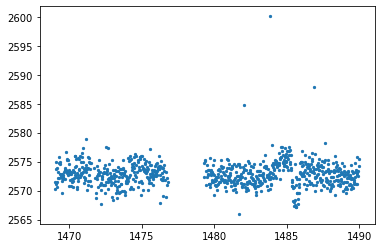

In [123]:
plt.scatter(lc['time'],lc['corrected flux'],s=5)

In [124]:
#lc_cut = lc[200:400]
lc_cut = lc[550:700]

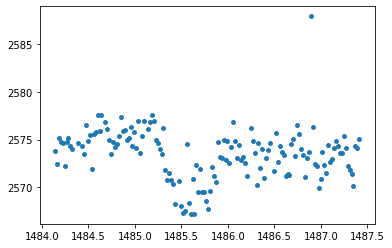

In [125]:
plt.scatter(lc_cut['time'],lc_cut['corrected flux'],s=15)

In [126]:
t = lc_cut['time']
f = normalise_flux(lc_cut['corrected flux'])
fe = normalise_flux(lc_cut['flux error'])

In [127]:
params, pcov = skewed_gaussian_curve_fit(t,f,fe)

In [128]:
fe.min()

-0.0013111194027836115

In [130]:
params, pcov = skewed_gaussian_curve_fit(x=t,y=f,y_err=fe)

fit = skewed_gaussian(lc_cut['time'], *params)

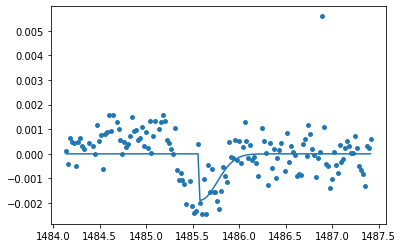

In [131]:
plt.scatter(t,f,s=15)
plt.plot(t,fit)

In [132]:
params

array([2.36750197e-03, 1.48557890e+03, 1.84940551e-01, 2.57445325e+03])

In [16]:
from scipy.stats import skew

sample_skewness = skew(lc_cut['corrected flux'])

In [17]:
sample_skewness

-3.6759387777044203

In [18]:
mean_cutout = np.mean(lc_cut['corrected flux'])
std_cutout = np.std(lc_cut['corrected flux'])

lower_bound = mean_cutout - 4 * std_cutout
upper_bound = mean_cutout + 4 * std_cutout

# Data points within the range [mean - 3*std, mean + 3*std]
filtered_cutout = lc_cut[(lc_cut['corrected flux'] >= lower_bound) & (lc_cut['corrected flux'] <= upper_bound)]


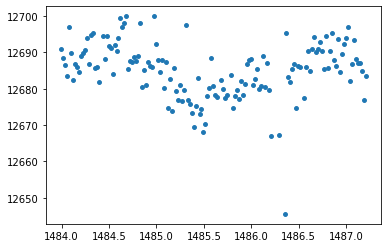

In [19]:
plt.scatter(filtered_cutout['time'],filtered_cutout['corrected flux'],s=15)

In [20]:
skew_est = skew(filtered_cutout['corrected flux'])
i = np.argmin(filtered_cutout['corrected flux'])
width = filtered_cutout['time'][-1]-filtered_cutout['time'][0]

In [21]:
params,cov = curve_fit(skewed_gaussian,filtered_cutout['time'],filtered_cutout['corrected flux'],p0=[20,filtered_cutout['time'][i],width/3,filtered_cutout['corrected flux'][i]],maxfev=100000)

In [22]:
fit = skewed_gaussian(filtered_cutout['time'], *params)

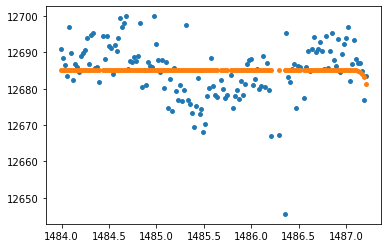

In [23]:
plt.scatter(filtered_cutout['time'],filtered_cutout['corrected flux'],s=15)
plt.scatter(filtered_cutout['time'],fit,s=15)

---

## Try old comet curve fit

In [53]:
def comet_curve(t,A,t0,sigma,tail):
    """
    Function: Calculates the values of an asymmetric Gaussian function representing a comet curve. 
    The difference is the exponential 1/tail term after the mid-transit.

    Parameters:
        t (array): Independent variable (time) values.
        A (float): Amplitude of the Gaussian curve.
        t0 (float): Mean (centre) of the Gaussian curve.
        sigma (float): Standard deviation of the Gaussian curve.
        tail (float): Tail parameter controlling decay rate after t0.

    Returns:
        array: The computed values of the asymmetric Gaussian curve."""

    x = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0:
            x[i] = gauss(t[i],A,t0,sigma)
        else:
            x[i] = A*math.exp(-abs(t[i]-t0)/tail)
    return x

def comet_curve_fit(x,y):
    # Initial parameters guess
    # x = time
    # y = flux
    i = np.argmax(y)

    width = x[-1]-x[0]

    params_init = [y[i],x[i],width/3,width/3]

    params_bounds = [[0,x[0],0,0], [np.inf,x[-1],width/2,width/2]]
    params,cov = curve_fit(comet_curve,x,y,params_init,bounds=params_bounds)
    return params, cov

In [54]:
params2, pcov2 = comet_curve_fit(lc_cut['time'],-lc_cut['corrected flux'])

In [55]:
fit2 = -comet_curve(lc_cut['time'],*params2)

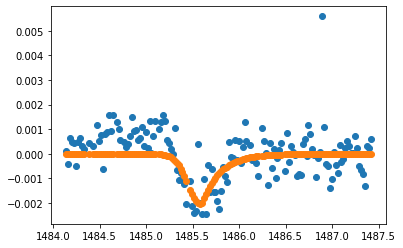

In [56]:
plt.scatter(lc_cut['time'],lc_cut['corrected flux'])
plt.scatter(lc_cut['time'],fit2)

In [96]:
len(lc_cut)

150

### Possible Combined Comet Model

In [102]:
def reverse_comet_curve(t,A,t0,sigma,tail):
    
    """
    Function: Calculates the values of an asymmetric Gaussian function representing a comet curve. 
    The difference is the exponential 1/tail term after the mid-transit.

    Parameters:
        t (array): Independent variable (time) values.
        A (float): Amplitude of the Gaussian curve.
        t0 (float): Mean (centre) of the Gaussian curve.
        sigma (float): Standard deviation of the Gaussian curve.
        tail (float): Tail parameter controlling decay rate after t0.

    Returns:
        array: The computed values of the asymmetric Gaussian curve."""

    x = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] > t0:
            x[i] = gauss(t[i],A,t0,sigma)
        else:
            x[i] = A*math.exp(-abs(t[i]-t0)/tail)
    return x


def combined_comet_model(t, A_forward, t0_forward, sigma_forward, tail_forward, A_reverse, t0_reverse, sigma_reverse, tail_reverse):
    """
    Function: Combines the forward and reverse comet models to create a combined comet model.

    Parameters:
        t (array): Independent variable (time) values.
        A_forward (float): Amplitude of the Gaussian curve for the forward comet.
        t0_forward (float): Mean (centre) of the Gaussian curve for the forward comet.
        sigma_forward (float): Standard deviation of the Gaussian curve for the forward comet.
        tail_forward (float): Tail parameter controlling the decay rate after t0 for the forward comet.
        A_reverse (float): Amplitude of the Gaussian curve for the reverse comet.
        t0_reverse (float): Mean (centre) of the Gaussian curve for the reverse comet.
        sigma_reverse (float): Standard deviation of the Gaussian curve for the reverse comet.
        tail_reverse (float): Tail parameter controlling the decay rate before t0 for the reverse comet.

    Returns:
        array: The computed values of the combined comet model.
    """

    combined_model = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0_forward:
            # Use forward comet model before t0_forward
            combined_model[i] = comet_curve(t[i], A_forward, t0_forward, sigma_forward, tail_forward)
        else:
            # Use reverse comet model after t0_forward
            combined_model[i] = reverse_comet_curve(t[i], A_reverse, t0_reverse, sigma_reverse, tail_reverse)

    return combined_model

In [103]:
fit2 = -comet_curve(lc_cut['time'],*params2)

In [104]:
fit3 = -reverse_comet_curve(lc_cut['time'],*params2)

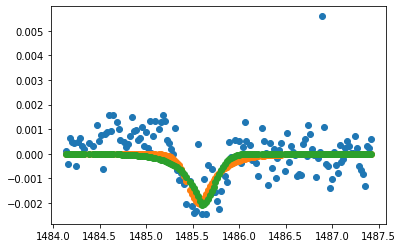

In [106]:
plt.scatter(lc_cut['time'],lc_cut['corrected flux'])
plt.scatter(lc_cut['time'],fit2)
plt.scatter(lc_cut['time'],fit3)

In [107]:
def combined_comet_model(t, A_forward, t0_forward, sigma_forward, tail_forward, A_reverse, t0_reverse, sigma_reverse, tail_reverse):
    """
    Function: Combines the forward and reverse comet models to create a combined comet model.

    Parameters:
        t (array): Independent variable (time) values.
        A_forward (float): Amplitude of the Gaussian curve for the forward comet.
        t0_forward (float): Mean (centre) of the Gaussian curve for the forward comet.
        sigma_forward (float): Standard deviation of the Gaussian curve for the forward comet.
        tail_forward (float): Tail parameter controlling the decay rate after t0 for the forward comet.
        A_reverse (float): Amplitude of the Gaussian curve for the reverse comet.
        t0_reverse (float): Mean (centre) of the Gaussian curve for the reverse comet.
        sigma_reverse (float): Standard deviation of the Gaussian curve for the reverse comet.
        tail_reverse (float): Tail parameter controlling the decay rate before t0 for the reverse comet.

    Returns:
        array: The computed values of the combined comet model.
    """

    combined_model = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0_forward:
            # Use forward comet model before t0_forward
            combined_model[i] = comet_curve(t[i], A_forward, t0_forward, sigma_forward, tail_forward)
        else:
            # Use reverse comet model after t0_forward
            combined_model[i] = reverse_comet_curve(t[i], A_reverse, t0_reverse, sigma_reverse, tail_reverse)

    return combined_model

In [109]:
fit4 = combined_comet_model(lc_cut['time'],*params2, *params2)

TypeError: object of type 'numpy.float64' has no len()